In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import calendar
import time

In [2]:
def plot_images(images, grid_size):
    plt.figure(figsize=(8,8))
    for n, image in enumerate(images[0:grid_size**2]):
        plt.subplot(grid_size, grid_size, n + 1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n)

def plot_dataset(d, grid_size, input=True):
    plt.figure(figsize=(8,8))
    for n, images in enumerate(d.take(grid_size**2)):
        plt.subplot(grid_size, grid_size, n + 1)
        image = images[0] if input else images[1]
        plt.imshow(tf.image.convert_image_dtype(image, dtype=tf.uint8))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n)

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(9, 9), filters=64, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(1, 1), filters=32, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [4]:
def prepare_input_image(original_image, input_size, scale):
    degraded_image = tf.image.resize(original_image, size=[input_size // scale, input_size // scale],
                                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.image.resize(degraded_image, size=[input_size, input_size],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.image.convert_image_dtype(input_image, dtype=tf.float32)

def prepare_output_image(original_image, input_size, output_size):
    if output_size == input_size & output_size == input_size:
        output = original_image
    else:
        new_x = (input_size - output_size) // 2 
        new_y = (input_size - output_size) // 2 
        output = tf.image.crop_to_bounding_box(original_image, new_y, new_x, output_size, output_size)
    return tf.image.convert_image_dtype(output, dtype=tf.float32)

def parse_function(filename, input_size, output_size, stride, scale):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string)
    crops = tf.image.extract_image_patches(tf.expand_dims(image, 0), [1, input_size, input_size, 1],
                                           [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
    crops = tf.reshape(crops[0], [-1, input_size, input_size, 3])
    input_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_input_image(img, input_size, scale))
    output_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_output_image(img, input_size, output_size))
    result = tf.data.Dataset.zip((input_dataset, output_dataset))
    return result

<DatasetV1Adapter shapes: ((32, 32, 3), (20, 20, 3)), types: (tf.float32, tf.float32)>


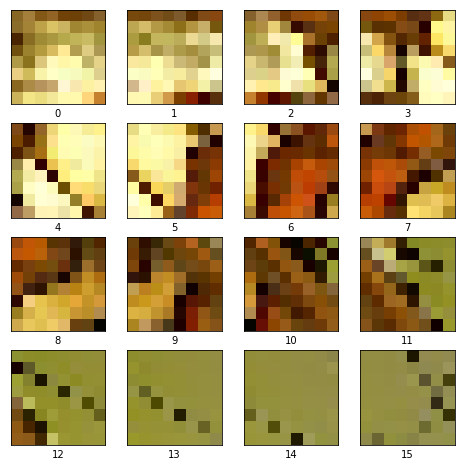

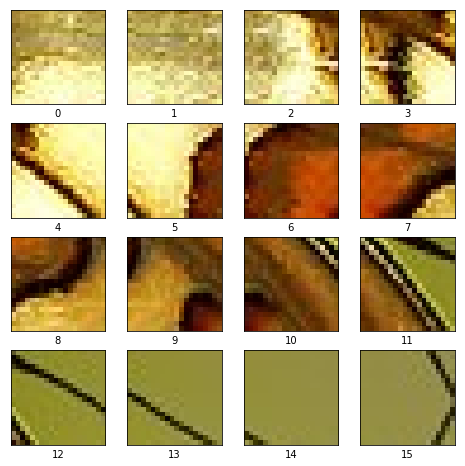

In [5]:
dataset = tf.data.Dataset.list_files("datasets/Train/*.bmp")
dataset = dataset.flat_map(lambda f: parse_function(f, input_size=32, output_size=20, stride=14, scale=4)).apply(tf.data.experimental.unbatch())
print(dataset)
plot_dataset(dataset, 4)
plot_dataset(dataset, 4, input=False)
batched_dataset = dataset.shuffle(1000).batch(100).repeat()

In [7]:
run_id=calendar.timegm(time.gmtime())
log_dir=f"logs/{run_id}/"
print(log_dir)
model.fit(batched_dataset, epochs=100, steps_per_epoch=100, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir)])

logs/1552873225/
Epoch 1/100
100/100 [==============================] - 10s 96ms/step - loss: 0.0180 - accuracy: 0.7610
Epoch 2/100
100/100 [==============================] - 9s 92ms/step - loss: 0.0063 - accuracy: 0.9130
Epoch 3/100
100/100 [==============================] - 9s 90ms/step - loss: 0.0036 - accuracy: 0.9334
Epoch 4/100
100/100 [==============================] - 9s 93ms/step - loss: 0.0059 - accuracy: 0.9353
Epoch 5/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0043 - accuracy: 0.9410
Epoch 6/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0062 - accuracy: 0.9000
Epoch 7/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0039 - accuracy: 0.9596
Epoch 8/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0047 - accuracy: 0.9607
Epoch 9/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0049 - accuracy: 0.9404
Epoch 10/100
100/100 [==============================] - 9s 89ms/

100/100 [==============================] - 9s 92ms/step - loss: 0.0045 - accuracy: 0.9584
Epoch 81/100
100/100 [==============================] - 9s 92ms/step - loss: 0.0051 - accuracy: 0.9175
Epoch 82/100
100/100 [==============================] - 9s 92ms/step - loss: 0.0043 - accuracy: 0.9533
Epoch 83/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0031 - accuracy: 0.9719
Epoch 84/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0043 - accuracy: 0.9247
Epoch 85/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0048 - accuracy: 0.9584
Epoch 86/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0033 - accuracy: 0.9634
Epoch 87/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0058 - accuracy: 0.9414
Epoch 88/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0038 - accuracy: 0.9537
Epoch 89/100
100/100 [==============================] - 9s 89ms/step - loss: 0.0047 - 

In [9]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs/1552873225/

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


W0318 04:57:49.340237 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.349964 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.359426 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.367377 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.379360 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.388996 140347540305728 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0318 04:57:49.401778 140347

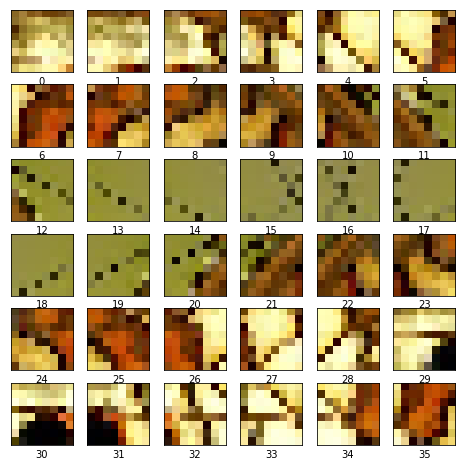

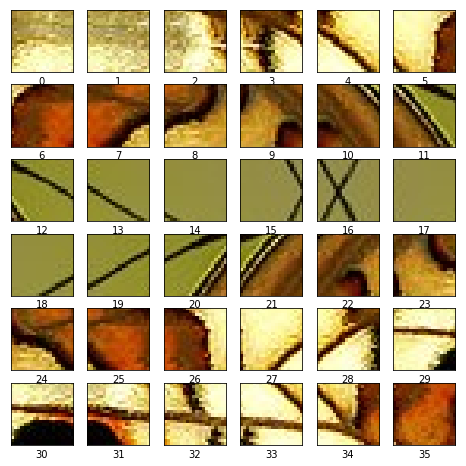

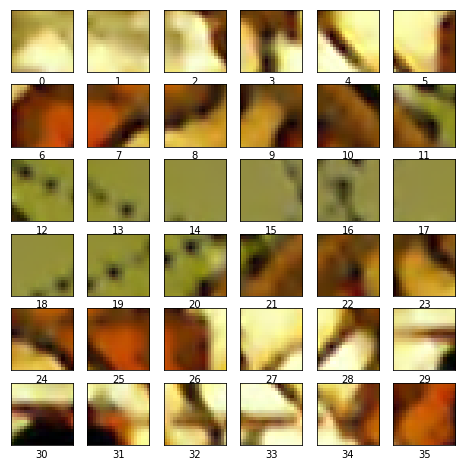

In [10]:
def plot_predictions(d, model, grid_size):
    inputs = d.take(grid_size**2)
    
    plot_dataset(inputs, grid_size)
    plot_dataset(inputs, grid_size, False)
    
    inputs = inputs.map(lambda x, y: x)
    inputs_list = []
    for i in inputs:
        inputs_list.append(i)
        
    outputs = model.predict(tf.stack(inputs_list))
    plot_images(outputs, grid_size)
    
plot_predictions(dataset, model, 6)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  15616     
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2080      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [13]:
import os
modeldir='models'
os.mkdir(modeldir)
model.save(f"{modeldir}/{run_id}.h5")